# Analizando un grupo de WhatsApp

En esta libreta analizaremos un grupo de whatssap llamado ***"Los viejos"***, haremos un analisis de datos para ver cuales son las palabras mas comunes como algunas graficas curiosas y relevantes sobre el grupo de whatssap. El archivo WhatsApp.txt fue sacado directamente desde la aplicación de WhatsApp de escritorio.

## SetUp 

In [1]:
!uv add pandas
!uv add wordcloud
!uv add matplotlib
!uv add numpy 
!uv add seaborn

import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Resolved 120 packages in 4ms
Audited 116 packages in 0.03ms
Resolved 120 packages in 4ms
Audited 116 packages in 0.03ms
Resolved 120 packages in 4ms
Audited 116 packages in 0.03ms
Resolved 120 packages in 5ms
Audited 116 packages in 0.03ms
Resolved 120 packages in 5ms
Audited 116 packages in 0.03ms


## Ingesta y limpieza de datos

Esta fase marca nuestra primera entrada a la bitácora de Ingeniería de Datos. El objetivo es leer el archivo de texto exportado (.txt) y transformarlo en un DataFrame estructurado. Logramos esto utilizando una **Expresión Regular (Regex)** intensiva, diseñada específicamente para parsear el formato \[Fecha y Hora\] Usuario: Contenido. La Regex nos permite identificar y extraer estos tres elementos clave de cada mensaje, creando nuestro DataFrame inicial (df\_raw) con el conteo total de mensajes listos para la siguiente fase de limpieza y transformación.

In [2]:
# Definir la ruta del archivo
FILE_PATH = 'WhatsApp Chat - Los Viejos.txt'

# Expresión Regular para el Formato de WhatsApp
# Esta regex está diseñada específicamente para tu ejemplo:
# [06/08/24, 6:10:44 a.m.] Caleb Jimenez: ‎sticker omitido
MESSAGE_REGEX = re.compile(
    r'^\[(\d{1,2}/\d{1,2}/\d{2,4}), (\d{1,2}:\d{2}:\d{2}\s?(?:a\.m\.|p\.m\.|[^\s]*?))\]\s([^:]+):\s(.*)',
    # GRUPO 1: Fecha (06/08/24)
    # GRUPO 2: Hora (6:10:44 a.m. - maneja el 'a.m.'/'p.m.' y formatos sin punto ni espacio extra)
    # GRUPO 3: Nombre de Usuario (Caleb Jimenez)
    # GRUPO 4: Contenido del Mensaje (‎sticker omitido)
    re.MULTILINE # Importante: permite que el ^ coincida al inicio de cada nueva línea de mensaje
)

def parse_whatsapp_chat(file_path):
    """Lee el archivo de chat y extrae los mensajes usando regex."""
    try:
        # Abrir y leer el contenido del chat. Usamos 'utf-8' para emojis y caracteres especiales.
        with open(file_path, 'r', encoding='utf-8') as f:
            chat_content = f.read()
    except FileNotFoundError:
        print(f"ERROR: Archivo no encontrado en: {file_path}")
        return pd.DataFrame()

    # Buscar todas las coincidencias de la regex en el contenido del chat
    messages = []
    for match in MESSAGE_REGEX.finditer(chat_content):
        fecha, hora_str, user, message = match.groups()
        
        # Combinar fecha y hora para facilitar la conversión a datetime
        datetime_str = f"{fecha} {hora_str.strip()}"
        
        messages.append({
            'Fecha_Hora_Str': datetime_str,
            'Usuario_Original': user.strip(),
            'Contenido': message.strip()
        })
    
    # Crear el DataFrame inicial
    df = pd.DataFrame(messages)
    
    return df

# Ejecutar la función para obtener el DataFrame
df_raw = parse_whatsapp_chat(FILE_PATH)

print(f"Total de mensajes extraídos: {len(df_raw)}")
print("\nPrimeras 5 filas del DataFrame extraído:")
df_raw.head()

Total de mensajes extraídos: 2462

Primeras 5 filas del DataFrame extraído:


,Fecha_Hora_Str,Usuario_Original,Contenido
0,09/08/24 8:18:19 p.m.,Francisco Ortega🍞🧀,Ya es agosto alv
1,09/08/24 8:18:29 p.m.,Francisco Ortega🍞🧀,Faltan 1 mes y una semana para el día
2,10/08/24 12:39:47 a.m.,Alejandro Munguia,Se viene 🔥🔥🔥🔥
3,10/08/24 12:39:51 a.m.,Alejandro Munguia,😍
4,10/08/24 8:59:20 a.m.,Rubén Ballesteros,Por qué o qué?


### Más limpieza

Continuamos con la **limpieza de datos**. El foco ahora es la columna de tiempo: convertir la cadena de texto (Fecha\_Hora\_Str) a un formato utilizable por Pandas (**datetime**).

Usamos una pequeña manipulación de cadenas con **regex** para estandarizar los indicadores a.m. / p.m. (eliminando puntos y espacios raros) y, finalmente, aplicamos pd.to\_datetime. Esto nos permite desechar las filas con errores de formato y garantizar que la columna **Fecha\_Hora** quede perfecta para los análisis de distribución de tiempo (horas y días).

In [3]:
#Función de Conversión a Datetime (Versión Corregida)
def convert_to_datetime_fixed(df_raw):
    """Convierte la columna de cadena de fecha/hora a un objeto datetime con manejo de errores."""
    
    # Limpiar el caracter especial de espacio y eliminar puntos en a.m./p.m.
    # Esto convierte 'p.m.' en 'pm' y limpia el espacio Unicode especial.
    df_raw['Fecha_Hora_Str'] = (
        df_raw['Fecha_Hora_Str']
        .str.replace(r'[\u202f\s]', ' ', regex=True) # Limpia espacios
        .str.replace('.', '', regex=False)           # Quita todos los puntos (p.m. -> pm)
        .str.strip()
    )

    # El nuevo formato sin puntos
    # %p en Pandas puede manejar 'AM', 'PM', 'am', 'pm' (depende de la configuración regional, pero sin puntos es más robusto)
    DATE_FORMAT_NEW = '%d/%m/%y %I:%M:%S %p'
    
    # Intenta la conversión
    df_raw['Fecha_Hora'] = pd.to_datetime(
        df_raw['Fecha_Hora_Str'], 
        format=DATE_FORMAT_NEW, 
        errors='coerce', 
        dayfirst=True
    )
    
    # Depuración: Mostrar la cadena que falló en la conversión
    failed_rows = df_raw[df_raw['Fecha_Hora'].isna()]
    if not failed_rows.empty:
        print(f"\nADVERTENCIA: Fallaron {len(failed_rows)} filas en la conversión.")
        print("Ejemplo de cadena de tiempo fallida:")
        print(failed_rows['Fecha_Hora_Str'].iloc[0])

    df_raw.dropna(subset=['Fecha_Hora'], inplace=True)
    
    return df_raw.drop(columns=['Fecha_Hora_Str'])

# Aplicar la conversión
df = convert_to_datetime_fixed(df_raw.copy())

print(f"\nMensajes después de la limpieza de fecha/hora: {len(df)}")
print(df.head())


Mensajes después de la limpieza de fecha/hora: 2462
     Usuario_Original                              Contenido  \
0  Francisco Ortega🍞🧀                       Ya es agosto alv   
1  Francisco Ortega🍞🧀  Faltan 1 mes y una semana para el día   
2  Alejandro  Munguia                          Se viene 🔥🔥🔥🔥   
3  Alejandro  Munguia                                      😍   
4   Rubén Ballesteros                         Por qué o qué?   

           Fecha_Hora  
0 2024-08-09 20:18:19  
1 2024-08-09 20:18:29  
2 2024-08-10 00:39:47  
3 2024-08-10 00:39:51  
4 2024-08-10 08:59:20  


Anonimización y Creación de Características (Feature Engineering)
------------------------------------------------------------------------

Esta etapa crucial prepara las **columnas finales** para el Análisis Exploratorio de Datos (EDA) anonimizando los nombres reales de los usuarios con personajes de ficción (columna **Usuario**) para mantener la privacidad, y simultáneamente, utilizando **Expresiones Regulares** para clasificar el **Tipo\_Mensaje** (Texto vs. Multimedia) y contar el **Num\_Palabras** en el contenido. Finalmente, extraemos componentes de tiempo (Hora, Día de la Semana) y creamos la métrica **Categoria\_Mensaje**, dejando el DataFrame completamente estructurado y listo para el análisis.

In [33]:
# Anonimización de Usuarios
# Lista de personajes de ficción para anonimizar..
personajes_ficcion = [
    'Neo', 'Trinity', 'Morpheus', 'Agente Smith', 'Oráculo', 'Batman', 'Superman', 
    'Mujer Maravilla', 'Gandalf', 'Frodo', 'Aragorn', 'Legolas', 'Gimli', 'Sauron'
    ,'Harry Potter', 'Messi', "Buda"
]
usuarios_unicos = df['Usuario_Original'].unique()

# Crear un diccionario de mapeo
user_mapping = {
    original: ficcion for original, ficcion in zip(usuarios_unicos, personajes_ficcion[:len(usuarios_unicos)])
}
df['Usuario'] = df['Usuario_Original'].map(user_mapping)

# Tipo de Mensaje (Usando Regex)
# Patrones para clasificar mensajes que no son texto puro
PATTERNS = {
    'Imagen': re.compile(r'<Imagen omitida>', re.IGNORECASE),
    'Video': re.compile(r'<Video omitido>', re.IGNORECASE),
    'Audio': re.compile(r'<Audio omitido>', re.IGNORECASE),
    'Sticker': re.compile(r'sticker omitido', re.IGNORECASE),
    'Sistema': re.compile(r'(se unió usando el enlace de invitación|salió|añadió|cambió|eliminó)', re.IGNORECASE)
}

def get_message_type(content):
    if pd.isna(content): return 'Otro'
    for msg_type, pattern in PATTERNS.items():
        if pattern.search(content): return msg_type
    return 'Texto'

df['Tipo_Mensaje'] = df['Contenido'].apply(get_message_type)


#Número de Palabras (Solo para 'Texto') usando Regex 
WORD_COUNT_REGEX = re.compile(r'\b\w+\b')

def count_words(row):
    # Usamos .lower() antes de contar para mayor robustez
    if row['Tipo_Mensaje'] == 'Texto':
        return len(WORD_COUNT_REGEX.findall(row['Contenido'].lower()))
    return 0

df['Num_Palabras'] = df.apply(count_words, axis=1)


# Componentes de Tiempo (Para gráficas) 
df['Hora'] = df['Fecha_Hora'].dt.hour
df['Dia_Semana'] = df['Fecha_Hora'].dt.day_name()
# Columna para agrupar en Texto vs. Multimedia/Sticker
df['Categoria_Mensaje'] = df['Tipo_Mensaje'].apply(lambda x: 'Texto Puro' if x == 'Texto' else 'Multimedia/Sticker')

print("\nDataFrame con Nuevas Características (Primeras Filas):")
print(df[['Usuario', 'Tipo_Mensaje', 'Num_Palabras', 'Hora']].head())



DataFrame con Nuevas Características (Primeras Filas):
    Usuario Tipo_Mensaje  Num_Palabras  Hora
0       Neo        Texto             4    20
1       Neo        Texto             9    20
2   Trinity        Texto             2     0
3   Trinity        Texto             0     0
4  Morpheus        Texto             4     8


Análisis Exploratorio de Datos (EDA) - Estadísticas
---------------------------------------------------------

Iniciamos la fase de **Análisis Exploratorio de Datos (EDA)** con las estadísticas descriptivas. En esta sección, cuantificamos la **actividad general** del grupo.

Calculamos métricas clave como el **número total de mensajes**, la **cantidad de usuarios únicos** y el **promedio de mensajes por usuario** para entender la escala de participación. Además, observamos la distribución porcentual del **Tipo de Mensaje** para ver qué tan dominante es el texto puro frente a la multimedia (imágenes, _stickers_, etc.). Estos números nos ofrecen una base sólida para interpretar las gráficas siguientes.

In [5]:
# Calculamos las estadísticas descriptivas
print("--- Estadísticas Descriptivas del Grupo ---")

total_mensajes = len(df)
total_usuarios = df['Usuario'].nunique()
mensajes_por_usuario = df.groupby('Usuario').size().mean()
fecha_inicio = df['Fecha_Hora'].min().strftime('%Y-%m-%d')
fecha_fin = df['Fecha_Hora'].max().strftime('%Y-%m-%d')
duracion_dias = (df['Fecha_Hora'].max() - df['Fecha_Hora'].min()).days

print(f"Total de Mensajes: {total_mensajes}")
print(f"Total de Usuarios Únicos: {total_usuarios}")
print(f"Promedio de Mensajes por Usuario: {mensajes_por_usuario:.2f}")
print(f"Período del chat: del {fecha_inicio} al {fecha_fin} ({duracion_dias} días)")

# Estadísticas de tipos de mensaje
print("\nConteo por Tipo de Mensaje:")
print(df['Tipo_Mensaje'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

--- Estadísticas Descriptivas del Grupo ---
Total de Mensajes: 2462
Total de Usuarios Únicos: 13
Promedio de Mensajes por Usuario: 189.38
Período del chat: del 2024-08-09 al 2025-09-30 (416 días)

Conteo por Tipo de Mensaje:
Tipo_Mensaje
Texto      99.68%
Sistema     0.32%
Name: proportion, dtype: object


Análisis Exploratorio de Datos (EDA) - Nube de Palabras
-------------------------------------------------------------

Tras estandarizar nuestro DataFrame, procedemos a generar la **Nube de Palabras** para responder a la pregunta: **¿Cómo se habla en este grupo?**

El proceso inicia con la **limpieza final del contenido** usando Regex para eliminar URLs y puntuación. Luego, refinamos drásticamente el conjunto de **Stopwords** (palabras de paro), añadiendo jerga específica y términos que, aunque frecuentes, no aportan valor temático (como jajaja o nombres propios), lo que nos permite **enfocarnos en los verdaderos temas de conversación**.

Finalmente, generamos la nube sin aplicar máscara para asegurar la máxima densidad y legibilidad de las 100 palabras más frecuentes.

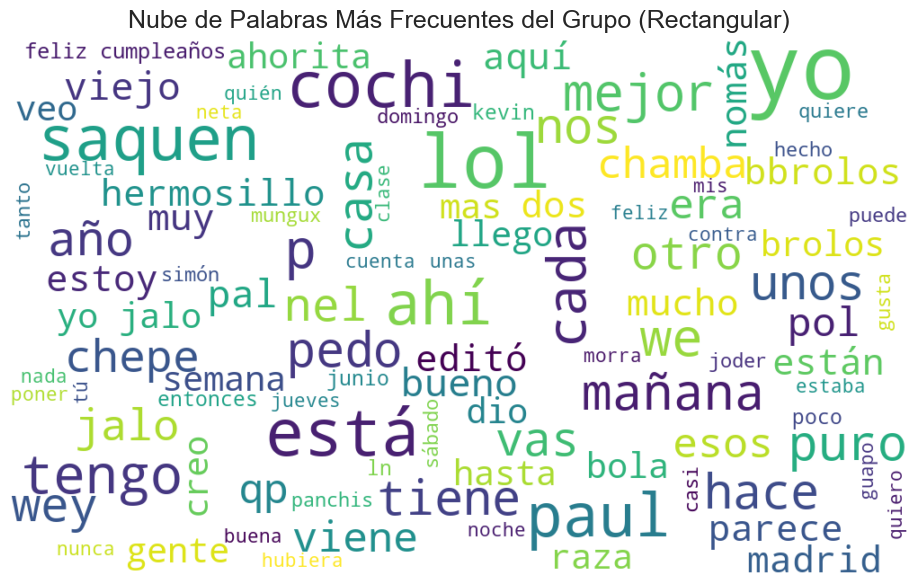

In [6]:
sns.set_style("whitegrid")

#Preparación del Texto
text_data_df = df[df['Tipo_Mensaje'] == 'Texto']
texto = ' '.join(text_data_df['Contenido'].astype(str).str.lower().values)

# Limpieza con Regex: Eliminar URLs y puntuación
texto = re.sub(r'http\S+|www.\S+', '', texto)
texto = re.sub(r'[^\w\s]', ' ', texto) 

#Definición de Stopwords
palabras_paro = set([
    'de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'un', 'por', 'con', 
    'no', 'una', 'su', 'para', 'es', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'me', 'si', 
    'este', 'o', 'ha', 'te', 'mi', 'ya', 'les', 'hay', 'porque', 'mismo', 'todo', 'esta',
    'cuando', 'ser', 'son', 'desde', 'fue', 'también', 'eso', 'estar', 'hacer', 'así', 
    'solo', 'ir', 'voy', 'va', 'haber', 'gracias', 'hola', 'qué', 'tal', 'días', 'día',
    "mas"
    # Jerga y omitidos del chat
    "whatsapp", "omitida", "sticker", "imagen", "video", "audio", "documento", 
    "multimedia", "contacto", "jajaja", "jeje", "jajajaja", "jaja", "jajaj", 
    "fc", "pumple", "mensaje", "foto", "dice", "sea", "sí", "nomas", "jajaja", "pa",
    "xd", "van", "q", "morra"
    # Añadimos algunas palabras que salieron muy grandes en la imagen:
    "yo", "uno", "puedo", "todos", "ni", "otra", "esa", "otra", "algo", "madre", "ver", "pues", 
    "bien", "tu", "hora", "pues", "ese", "hora", "vez", "menos", "uno", "estan", "tenemos", "ando", 
    "ahi", "le", "donde", "hoy", "anda", "tiempo", "pasa", "mira" , "soy", "sin", "jajajaj", "mas"
    "pal", "jajajajaja", "p"
    #Añadimos algunas groserias
    "puto", "pinche", "joto", "pendejo", "verga", "alv", "culo"
])

#ESTAS PALABRAS NO ME REPRESENTAN COMO PERSONA, LO JURO

#Generar la Nube de Palabras SIN MÁSCARA
wc = WordCloud(
    stopwords=palabras_paro,
    max_words=100,
    background_color="white", 
    width=1000,          
    height=600,          
    max_font_size=100,   
    min_font_size=8,     
    relative_scaling=0.5, 
    prefer_horizontal=0.9,
    random_state=42
).generate(texto)

# Mostrar el resultado 
plt.figure(figsize=(12, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras Más Frecuentes del Grupo (Rectangular)", fontsize=18)
plt.show()

Finalmente, usamos una máscara binaria personalizada (círculo blanco sobre fondo negro) en un intento por forzar el empaquetamiento de las 100 palabras más frecuentes en una forma circular densa, ofreciendo una vista rápida de los términos dominantes en el chat.

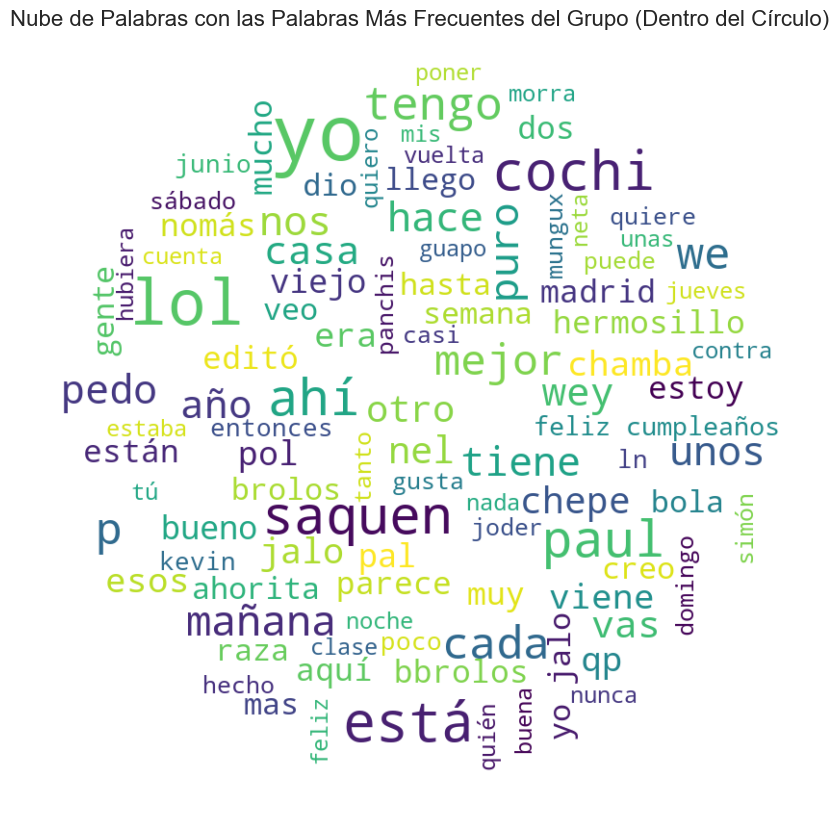

In [7]:
# Crear la Máscara de Círculo Relleno 
width_mask = 800
height_mask = 800
radius = 380 
center_x, center_y = width_mask // 2, height_mask // 2

# Imagen blanca (fondo)
mask_image = np.ones((height_mask, width_mask), dtype=np.uint8) * 255

# Círculo negro (donde se dibujarán las palabras)
Y, X = np.ogrid[:height_mask, :width_mask]
distance_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
mask_image[distance_from_center <= radius] = 0  # Interior = 0 (permitido para texto)

# Generar la Nube de Palabras
wc = WordCloud(
    stopwords=palabras_paro,
    max_words=100,
    background_color="white", 
    width=width_mask, 
    height=height_mask,
    mask=mask_image,
    contour_color=None,
    max_font_size=80,      
    min_font_size=10,      
    relative_scaling=0.5,  
    prefer_horizontal=0.9, 
    random_state=42
).generate(texto)

# Mostrar 
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras con las Palabras Más Frecuentes del Grupo (Dentro del Círculo)", fontsize=16)
plt.show()


Análisis Exploratorio de Datos (EDA) - Usuarios Más Activos
-----------------------------------------------------------------

Tras estructurar la data, pasamos a responder la pregunta: **¿Quiénes son los que más escriben?**

Utilizamos la columna **Usuario** (anonimizada) para contar el número total de mensajes por persona. Generamos una **gráfica de barras** que ordena a los usuarios de mayor a menor actividad. Esta visualización nos permite identificar rápidamente a los **participantes clave** y a los **motores de la conversación** dentro del grupo. Notarás que hemos ajustado la sintaxis de sns.barplot para eliminar los _FutureWarnings_ de Seaborn.

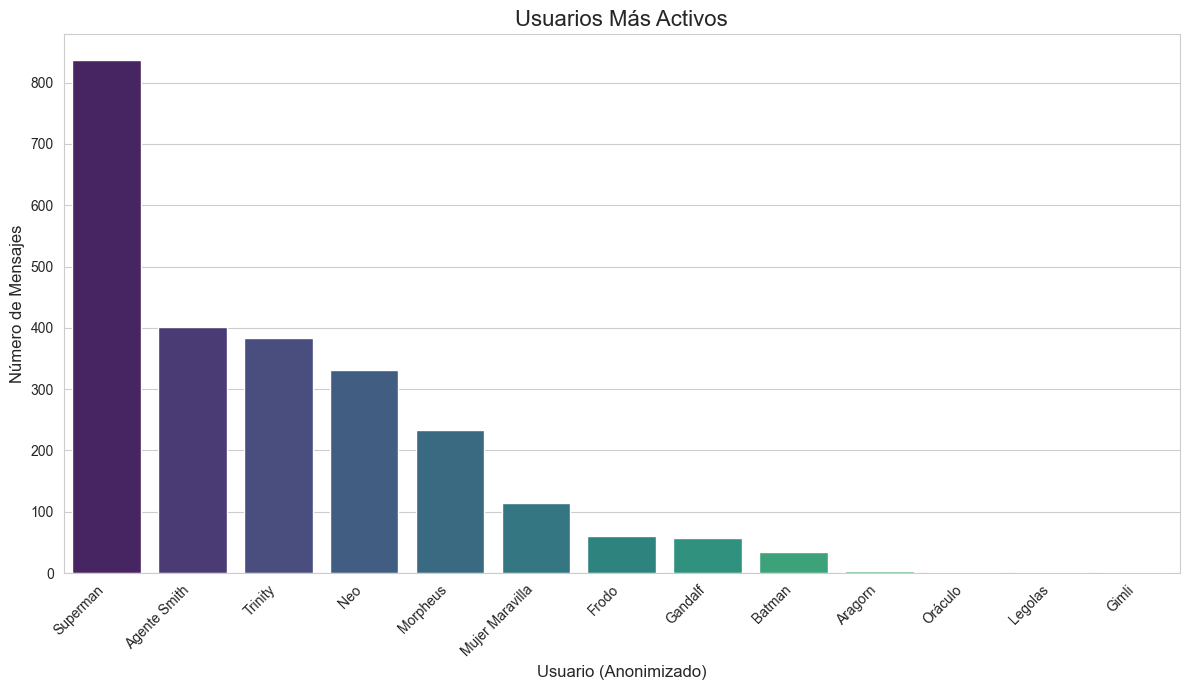

In [8]:
# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

#Conteo de mensajes por usuario
user_counts = df['Usuario'].value_counts().sort_values(ascending=False)

# Convertir la serie de conteo a un DataFrame explícito
user_counts_df = user_counts.reset_index()
user_counts_df.columns = ['Usuario', 'Num_Mensajes']


plt.figure(figsize=(12, 7))
sns.barplot(
    data=user_counts_df,
    x='Usuario',
    y='Num_Mensajes',
    hue='Usuario',    
    palette="viridis",
    legend=False        # Ocultamos la leyenda redundante
)

#Personalización de la gráfica
plt.title('Usuarios Más Activos', fontsize=16)
plt.xlabel('Usuario (Anonimizado)', fontsize=12)
plt.ylabel('Número de Mensajes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Análisis Exploratorio de Datos (EDA) - Distribución Horaria
-----------------------------------------------------------------

Esta gráfica nos ayuda a responder la pregunta: **¿A qué horas se envían más mensajes?**

Para ello, analizamos la columna **Hora** (previamente extraída de la fecha y hora completa) para contar la frecuencia de mensajes por cada hora del día (0 a 23). La visualización de **líneas** es ideal para mostrar la tendencia de actividad, identificando los **picos de conversación** y los periodos de silencio del grupo a lo largo de un ciclo de 24 horas.

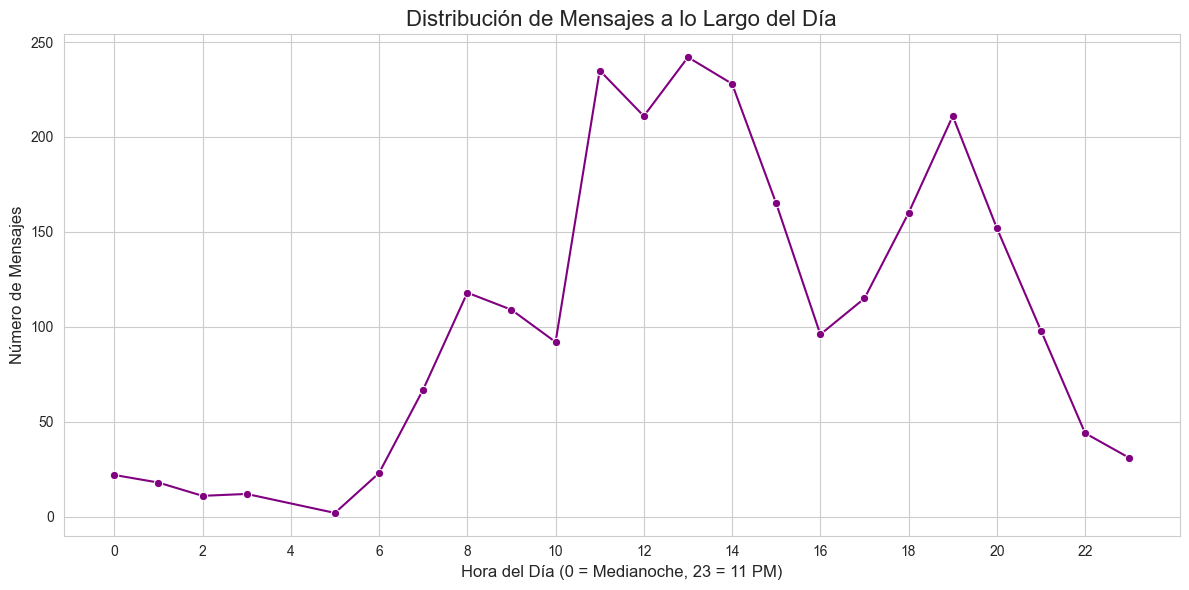

In [9]:
hourly_counts = df['Hora'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, marker='o', color='purple')
plt.title('Distribución de Mensajes a lo Largo del Día', fontsize=16)
plt.xlabel('Hora del Día (0 = Medianoche, 23 = 11 PM)', fontsize=12)
plt.ylabel('Número de Mensajes', fontsize=12)
plt.xticks(range(0, 24, 2))
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Análisis Exploratorio de Datos (EDA) - Actividad Semanal
--------------------------------------------------------------

Esta gráfica aborda la pregunta: **¿Qué días son los más activos?**

Para asegurar una representación precisa, primero **mapeamos los nombres de los días** al español y reordenamos el conteo (columna **Dia\_Semana\_ES**) cronológicamente de lunes a domingo. La **gráfica de barras** resultante muestra el volumen de mensajes por día, permitiéndonos identificar patrones claros de actividad.

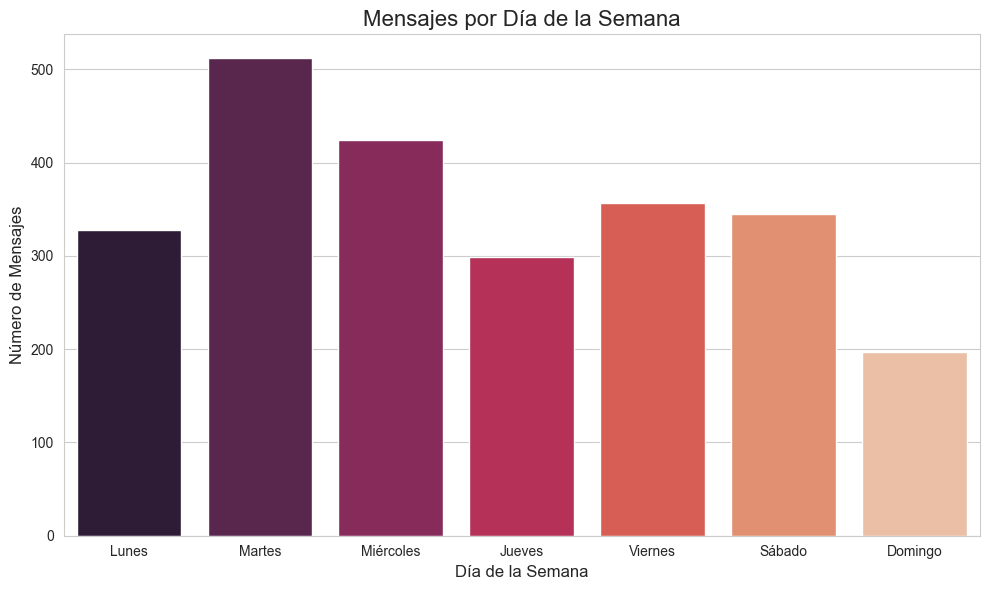

In [10]:
# Definir el orden correcto de los días
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Mapeo a español
day_mapping = {
    'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles', 
    'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sábado', 'Sunday': 'Domingo'
}

# Crear la columna en español
df['Dia_Semana_ES'] = df['Dia_Semana'].map(day_mapping)

# Contar y reindexar para asegurar el orden
day_counts = df['Dia_Semana_ES'].value_counts().reindex([day_mapping[d] for d in day_order], fill_value=0)

#Convertir la serie de conteo a un DataFrame para Seaborn 
day_counts_df = day_counts.reset_index()
day_counts_df.columns = ['Dia', 'Num_Mensajes']

plt.figure(figsize=(10, 6))


sns.barplot(
    data=day_counts_df,
    x='Dia',
    y='Num_Mensajes',
    hue='Dia',      
    palette="rocket",
    legend=False
)

plt.title('Mensajes por Día de la Semana', fontsize=16)
plt.xlabel('Día de la Semana', fontsize=12)
plt.ylabel('Número de Mensajes', fontsize=12)
plt.tight_layout()
plt.show()

Análisis Exploratorio de Datos (EDA) - Roles de Conversación
------------------------------------------------------------

Esta gráfica visualiza la dinámica social del grupo respondiendo a la pregunta: **¿Quién genera la conversación y quién la estimula?**

Agrupamos los mensajes por usuario y por categoría (**Texto Puro** vs. **Multimedia/Sticker**) para crear barras apiladas. Los segmentos de **texto** representan a los **generadores de contenido**, mientras que la **multimedia** representa a los **estimuladores** que reaccionan o aportan contenido visual breve. Esto ofrece una visión clara sobre los roles comunicativos de los usuarios anonimizados.

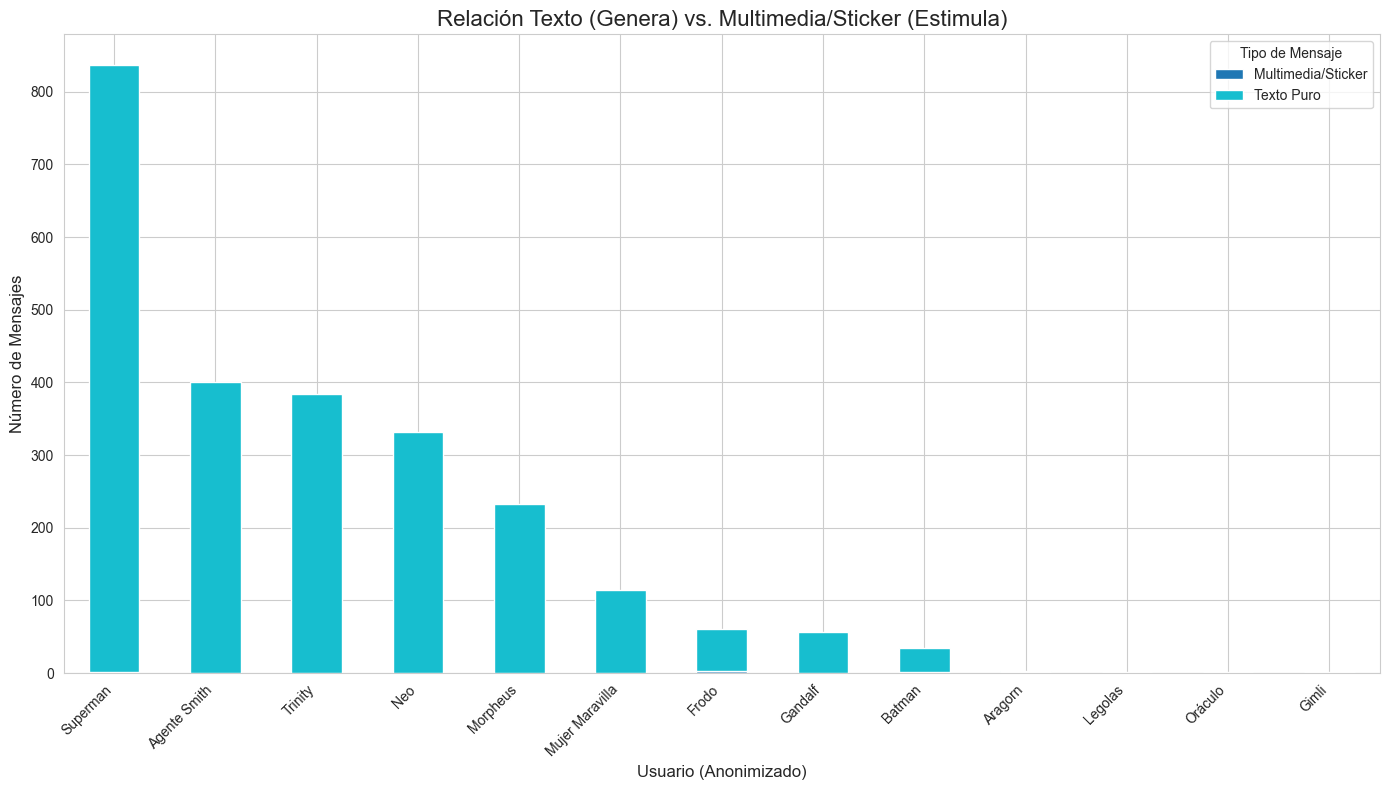

In [14]:
# Agrupación: Mensajes de Texto Puro vs. Otros por usuario
type_counts = df.groupby(['Usuario', 'Categoria_Mensaje']).size().unstack(fill_value=0)

# Calcular el total para ordenar
type_counts['Total'] = type_counts.sum(axis=1)
type_counts = type_counts.sort_values(by='Total', ascending=False).drop(columns='Total')

# Gráfico de barras apiladas
type_counts.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab10')
plt.title('Relación Texto (Genera) vs. Multimedia/Sticker (Estimula)', fontsize=16)
plt.xlabel('Usuario (Anonimizado)', fontsize=12)
plt.ylabel('Número de Mensajes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo de Mensaje', loc='upper right')
plt.tight_layout()
plt.show()

Otros Análisis - Uso de Jerga Coloquial
---------------------------------------

Para nuestro primer análisis adicional, exploramos la **cultura lingüística** del grupo respondiendo: **¿Quién utiliza más jerga coloquial?**

Primero, utilizamos una Regex para contar la frecuencia de palabras específicas consideradas como jerga (previamente definidas en JERGA\_WORDS) dentro de los mensajes. Luego, generamos esta **gráfica de barras** que muestra el **conteo total de jerga por usuario**. Esto nos permite identificar de manera visual a los usuarios que más emplean el lenguaje informal en el chat.

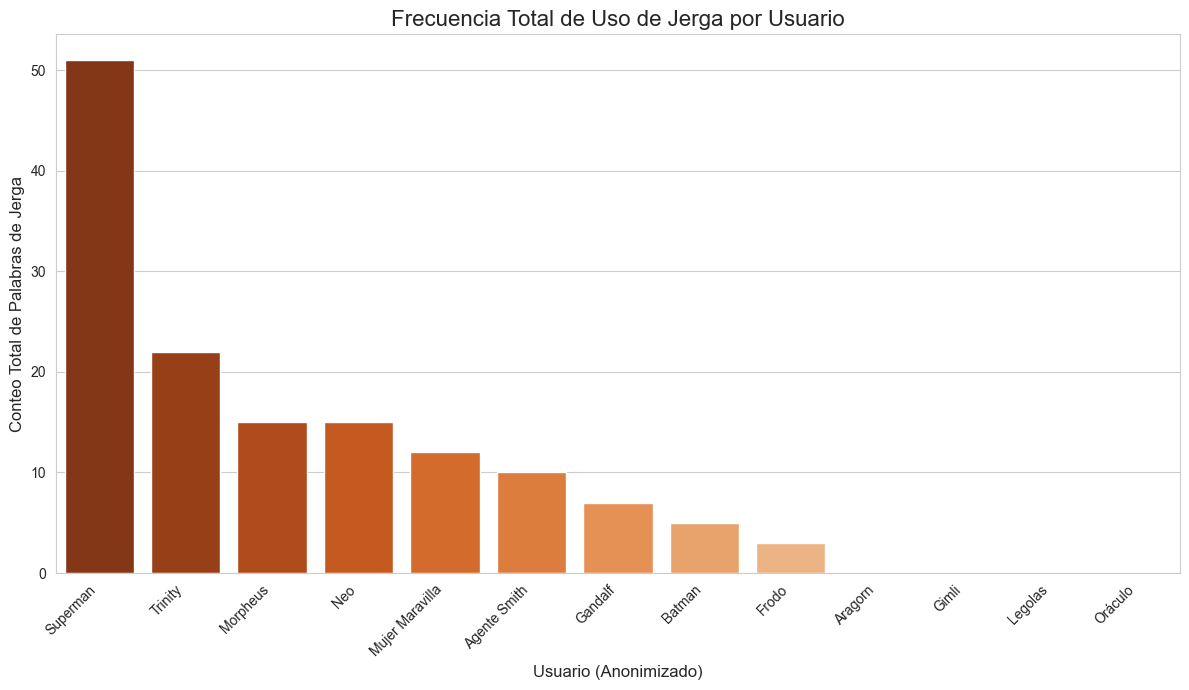

In [26]:
# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

#Conteo de jerga (Código base)
JERGA_WORDS = ['alv', 'pinche', 'puto', 'verga', 'pendejo', 'we', 'brolo', 'chepe', 'madre']
jerga_regex = re.compile(r'\b(' + '|'.join(JERGA_WORDS) + r')\b', re.IGNORECASE)

def count_jerga(content):
    """Cuenta las coincidencias de jerga en el contenido del mensaje."""
    if pd.isna(content):
        return 0
    return len(jerga_regex.findall(content))

df['Num_Jerga'] = df['Contenido'].apply(count_jerga)
jerga_per_user = df.groupby('Usuario')['Num_Jerga'].sum().sort_values(ascending=False)


# Convertir la serie de conteo a un DataFrame para Seaborn
jerga_df = jerga_per_user.reset_index()
jerga_df.columns = ['Usuario', 'Conteo_Jerga']

#Generación de la gráfica de barras con sintaxis 
plt.figure(figsize=(12, 7))
sns.barplot(
    data=jerga_df,
    x='Usuario',
    y='Conteo_Jerga',
    hue='Usuario',      
    palette="Oranges_r",
    legend=False        # Ocultamos la leyenda
)

#Personalización de la gráfica
plt.title('Frecuencia Total de Uso de Jerga por Usuario', fontsize=16)
plt.xlabel('Usuario (Anonimizado)', fontsize=12)
plt.ylabel('Conteo Total de Palabras de Jerga', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Otros Análisis - Tasa de Iniciación de Conversación
---------------------------------------------------

Para nuestro segundo análisis adicional, exploramos la **dinámica de reactividad** del grupo preguntando: **¿Quién inicia las conversaciones?**

Primero, calculamos el tiempo de diferencia (lag) entre mensajes. Luego, definimos a un **"iniciador"** como el usuario que rompe un silencio prolongado (definido por UMBRAL\_INICIADOR\_MINUTOS). Finalmente, esta **gráfica de barras** muestra el **porcentaje de mensajes de cada usuario que caen en la categoría de "iniciador"**. Esto revela quién trae temas nuevos o revive el chat, en contraste con los usuarios que principalmente responden a mensajes recientes.

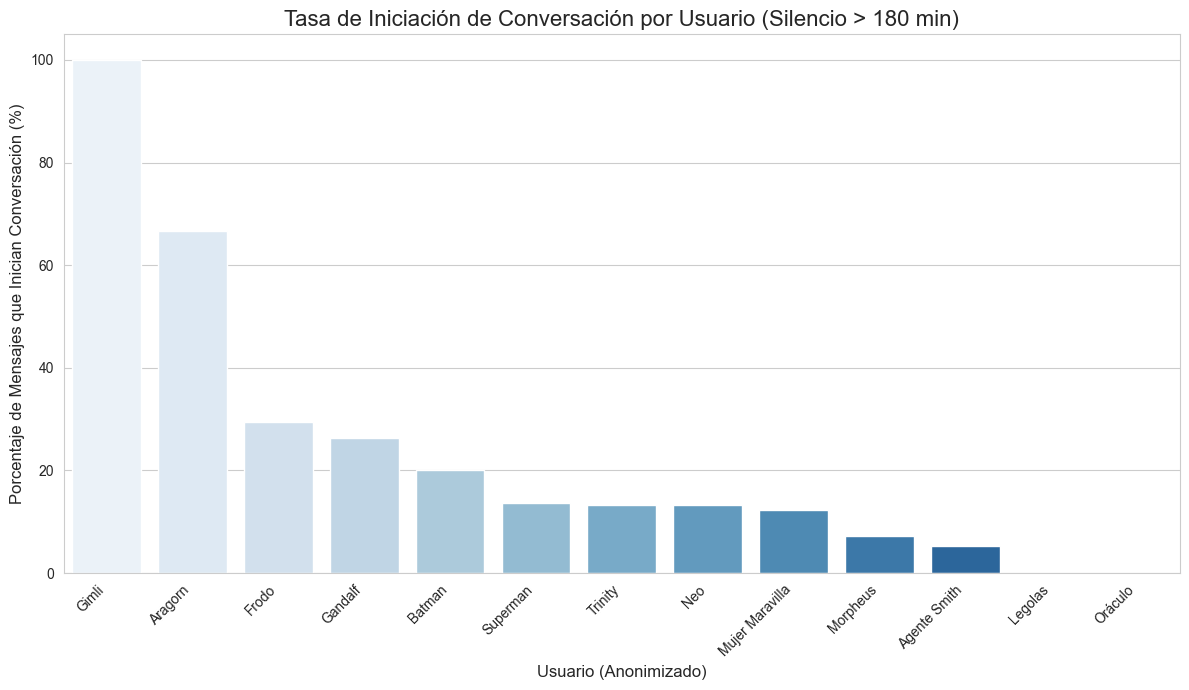

In [32]:
# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

# 5. Gráfica de Barras con sintaxis moderna
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=iniciacion_df,
    x='Usuario',
    y='Tasa_Iniciacion_Porcentaje',
    hue='Usuario',      
    palette="Blues"
)

if ax.get_legend() is not None:
    ax.get_legend().remove()

# Personalización de la gráfica
plt.title(f'Tasa de Iniciación de Conversación por Usuario (Silencio > {UMBRAL_INICIADOR_MINUTOS} min)', fontsize=16)
plt.xlabel('Usuario (Anonimizado)', fontsize=12)
plt.ylabel('Porcentaje de Mensajes que Inician Conversación (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()